# Past Years Library Usage

Business Question:

    The San Francisco Library is attempting to increase their annual patrons by re-exposing old patrons with targeted advertisement. 

This is an in depth analysis with the goal of understanding and classifying the old patrons into useful segments. 

Assumptions: 
- There are no incorrect values
- Only patrons from 2016 may be considered active

In [19]:
#import and read in data

import pandas as pd 
import numpy as np
import seaborn as sb
from matplotlib import rcParams
import matplotlib.pyplot as plt

%matplotlib inline
sb.set_style('whitegrid')
fig = plt.figure()

data = pd.read_csv('C:/Users/Scott/Desktop/Data/Library_Usage.csv')

Let's remove values containing:
- 2016 because they are active
- "None" because they are from another database and older than 2003

Patron Type Definition               0
Total Checkouts                      0
Total Renewals                       0
Age Range                          215
Home Library Definition              0
Circulation Active Month             0
Circulation Active Year              0
Notice Preference Definition         0
Provided Email Address               0
Year Patron Registered               0
Outside of County                    0
Supervisor District             110310
dtype: int64


C:\Users\Scott\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

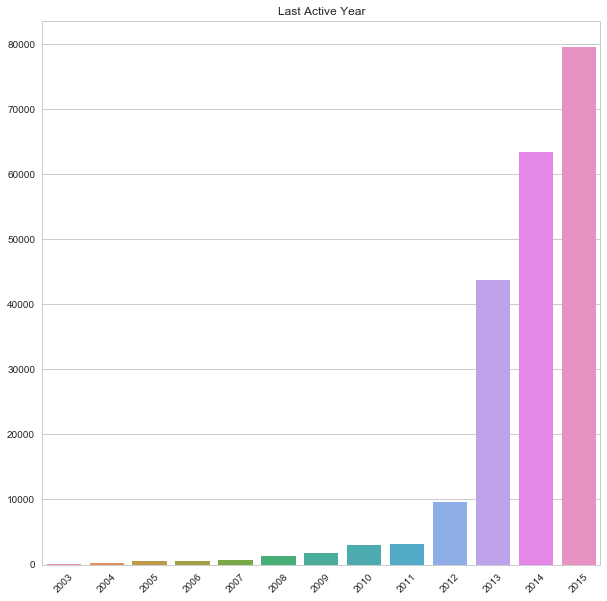

In [20]:
df = data
df = df.drop('Patron Type Code',1)
df = df.drop('Home Library Code',1)
df = df.drop('Notice Preference Code',1)

print(df.isnull().sum())
df = df.drop('Supervisor District',1)
df = df.dropna(axis=0)

df=df.loc[df['Circulation Active Year'] != '2016']
df=df.loc[df['Circulation Active Year'] != 'None']

plt.figure(figsize=(10,10))

#Last Active Year

grouping = df.groupby('Circulation Active Year')
num = grouping['Outside of County'].count()
ax = sb.barplot(x=num.index,y=num)
plt.ylabel('')
plt.xlabel('')
plt.title('Last Active Year')
plt.xticks(rotation= 45)

#### KMeans Clustering

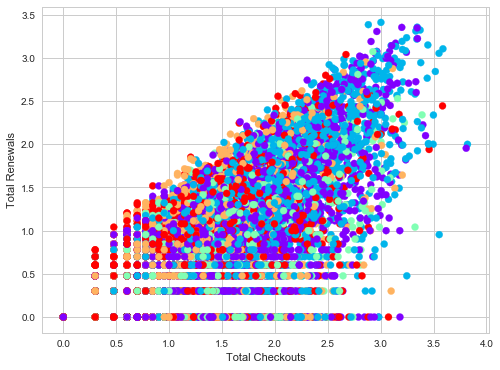

In [21]:
from sklearn.cluster import KMeans
from scipy import stats
from sklearn.preprocessing import scale 
from sklearn.preprocessing import LabelEncoder

df['checkouts']= np.log10(df['Total Checkouts']+1)
df['renewals'] = np.log10(df['Total Renewals']+1)

meaner = df.loc[:,('checkouts','renewals')]
num = LabelEncoder()
meaner['bin_age'] = num.fit_transform(df['Age Range'].astype('str'))
meaner['bin_Library'] = num.fit_transform(df['Home Library Definition'].astype('str'))
meaner['bin_Month'] = num.fit_transform(df['Circulation Active Month'].astype('str'))
meaner['bin_year'] = num.fit_transform(df['Circulation Active Year'].astype('str'))
meaner['bin_notice'] = num.fit_transform(df['Notice Preference Definition'].astype('str'))
meaner['bin_email'] = num.fit_transform(df['Provided Email Address'].astype('str'))
meaner['bin_registered'] = num.fit_transform(df['Year Patron Registered'].astype('str'))
meaner['bin_county'] = num.fit_transform(df['Outside of County'].astype('str'))
meaner = meaner.sample(frac=.05)
kmeans = KMeans(n_clusters=5)
kmeans = kmeans.fit(meaner)
labels = kmeans.labels_


plt.figure(figsize=(8,6))
plt.scatter(meaner['checkouts'], meaner['renewals'], c=labels,cmap='rainbow')
plt.ylabel('Total Renewals')
plt.xlabel('Total Checkouts')
plt.show()

This graphic hints at an idea of how a classifier may work.

#### SVM Classifier

train
0.840011014732
test
0.67469492614


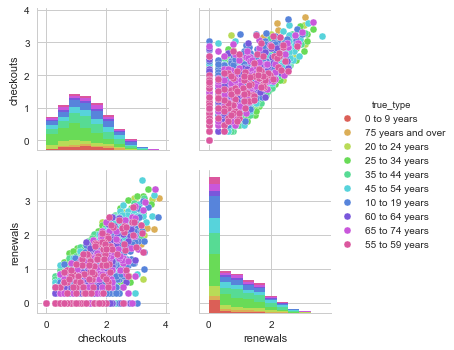

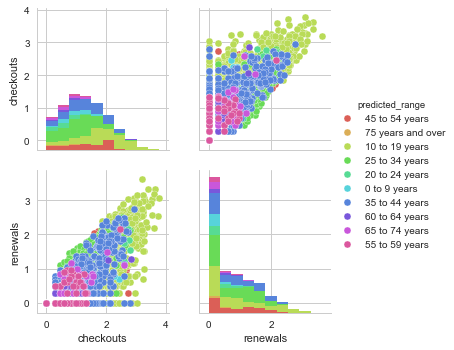

In [22]:
from sklearn import svm
from sklearn.model_selection import train_test_split

data = df.sample(frac=.05)
datay = data['Age Range']

data = data.drop('Patron Type Definition',1)
data = data.drop('checkouts',1)
data = data.drop('renewals',1)

datax = pd.get_dummies(data)
y = datay
x = datax.join(df['checkouts'])
x = x.join(df['renewals'])     
                              
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

clf = svm.SVC()
clf.fit(x_train, y_train)
predict = clf.predict(x_test)

print('train')
print(clf.score(x_train,y_train))
print('test')
print(clf.score(x_test,y_test))

plt.figure(figsize=(25,25))
true_rfc = x_test.loc[:,('checkouts','renewals')]
true_rfc['true_type'] = y_test
sb.pairplot(true_rfc, hue = 'true_type', palette = 'hls')

pred_rfc = x_test.loc[:,('checkouts','renewals')]
pred_rfc['predicted_range'] = predict
sb.pairplot(pred_rfc, hue = 'predicted_range', palette = 'hls')

These are the predicted groupings of train and test models. With the score being around 80% in the train model, but dropping significantly to 68% in the test. The large drop suggests there are problems with the model. In order to receive a better test score, it may be worth while to segment the users back into the low, high, and outlier slices.

In [29]:
med = np.median(df['checkouts'])
mid = np.median(df['renewals'])

low_df_slice = df.loc[df['checkouts'] <= med]
low_df_slice = low_df_slice.loc[low_df_slice['renewals'] <= mid]
print(len(low_df_slice))
high_df_slice = df.loc[df['checkouts'] > med]
high_df_slice = high_df_slice.loc[high_df_slice['renewals'] > mid]

low_high_df_slice = df.loc[df['checkouts'] <= med]
low_high_df_slice = low_high_df_slice.loc[low_high_df_slice['renewals'] > mid]

high_low_df_slice = df.loc[df['Total Checkouts'] > med]
high_low_df_slice = high_low_df_slice.loc[high_low_df_slice['renewals'] <= mid]

78145


### Low Activity 

train
0.991953182151
test
0.988064791134


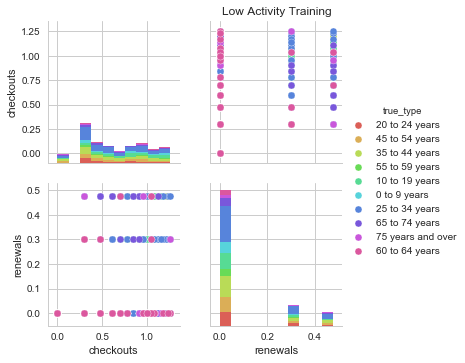

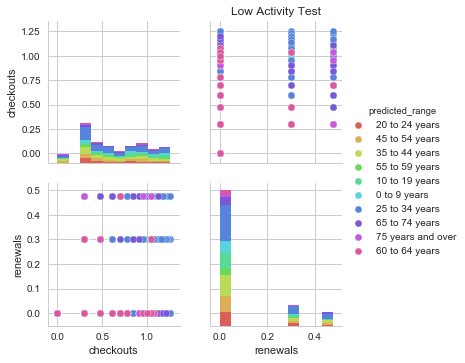

In [30]:
data = low_df_slice.sample(frac=.05)
datay = data['Age Range']

data = data.drop('Patron Type Definition',1)
data = data.drop('checkouts',1)
data = data.drop('renewals',1)

datax = pd.get_dummies(data)
y = datay
x = datax.join(df['checkouts'])
x = x.join(df['renewals'])     
                              
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

clf = svm.SVC()
clf.fit(x_train, y_train)
predict = clf.predict(x_test)

print('train')
print(clf.score(x_train,y_train))
print('test')
print(clf.score(x_test,y_test))

plt.figure(figsize=(25,25))
low_true_rfc = x_test.loc[:,('checkouts','renewals')]
low_true_rfc['true_type'] = y_test

low_pred_rfc = x_test.loc[:,('checkouts','renewals')]
low_pred_rfc['predicted_range'] = predict

sb.pairplot(low_true_rfc, hue = 'true_type', palette = 'hls')
plt.title('Low Activity Training')

sb.pairplot(low_pred_rfc, hue = 'predicted_range', palette = 'hls')
plt.title('Low Activity Test')

### High Activity

train
0.662513741297
test
0.298290598291


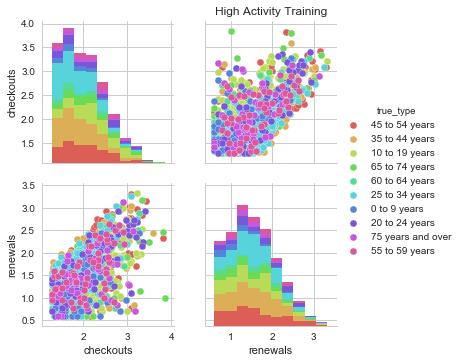

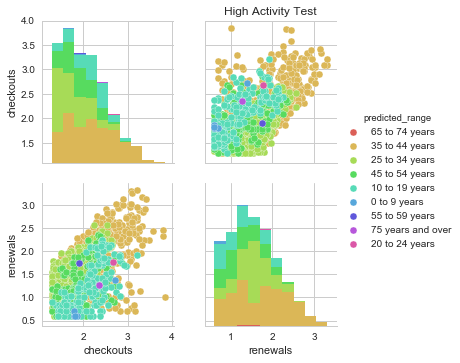

In [31]:
data = high_df_slice.sample(frac=.05)
datay = data['Age Range']

data = data.drop('Patron Type Definition',1)
data = data.drop('checkouts',1)
data = data.drop('renewals',1)

datax = pd.get_dummies(data)
y = datay
x = datax.join(df['checkouts'])
x = x.join(df['renewals'])     
                              
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

clf = svm.SVC()
clf.fit(x_train, y_train)
predict = clf.predict(x_test)

print('train')
print(clf.score(x_train,y_train))
print('test')
print(clf.score(x_test,y_test))

plt.figure(figsize=(25,25))
high_true_rfc = x_test.loc[:,('checkouts','renewals')]
high_true_rfc['true_type'] = y_test

high_pred_rfc = x_test.loc[:,('checkouts','renewals')]
high_pred_rfc['predicted_range'] = predict

sb.pairplot(high_true_rfc, hue = 'true_type', palette = 'hls')
plt.title('High Activity Training')

sb.pairplot(high_pred_rfc, hue = 'predicted_range', palette = 'hls')
plt.title('High Activity Test')

### Outliers